# Isolation Forest

# Load Data

In [1]:
import joblib
import os
# Load Scaled Data
# project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# processed_path = os.path.join(project_root, "Data", "Processed")

project_root = r"C:\Users\Nourhan\Documents\Graduation Project\AI_CyberSecurity"
processed_path = os.path.join(project_root, "Data", "Processed")

x_train_scaled = joblib.load(os.path.join(processed_path, "train_scaled.pkl"))
x_val_scaled   = joblib.load(os.path.join(processed_path, "val_scaled.pkl"))
x_test_scaled  = joblib.load(os.path.join(processed_path, "test_scaled.pkl"))
y_test         = joblib.load(os.path.join(processed_path, "test_labels.pkl"))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, auc,precision_recall_curve,ConfusionMatrixDisplay)
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

In [ ]:
best_f1 = 0
best_params = {}

for cont in [0.05, 0.07, 0.10, 0.15]:
    for n_est in [100, 200, 400]:
        for max_s in [100000, 300000, 500000]:
            iso = IsolationForest(n_estimators=n_est,
                                  max_samples=max_s,
                                  contamination=cont,
                                  random_state=42,
                                  n_jobs=-1)
            iso.fit(x_train_scaled)
            y_pred = iso.predict(x_test_scaled)
            y_pred = np.where(y_pred == -1, 1, 0)
            
            f1 = f1_score(y_test, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_params = {'contamination': cont, 'n_estimators': n_est, 'max_samples': max_s}

print("Best F1:", best_f1)
print("Best Params:", best_params)


Best F1: 0.9501744611141447
Best Params: {'contamination': 0.07, 'n_estimators': 400, 'max_samples': 500000}


# Isolation Forest

In [30]:
# Isolation Forest Model
iso_forest = IsolationForest(
    n_estimators=400,
    max_samples=500000, 
    contamination=0.07, 
    n_jobs=-1, 
    random_state=42)
iso_forest.fit(x_train_scaled)

,n_estimators,400
,max_samples,500000
,contamination,0.07
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


In [32]:
y_scores = iso_forest.decision_function(x_test_scaled)
y_pred   = iso_forest.predict(x_test_scaled)   # 1 = inlier, -1 = outlier

# Convert IsolationForest predictions to 0/1 labels
# -1 → anomaly → 1
#  1 → normal  → 0
y_pred_converted = np.where(y_pred == -1, 1, 0)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred_converted))
print("Precision:", precision_score(y_test, y_pred_converted))
print("Recall:", recall_score(y_test, y_pred_converted))
print("F1 Score:", f1_score(y_test, y_pred_converted))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_converted)
print("\nConfusion Matrix:\n", cm)

# Detailed report
print("\nClassification Report:\n", classification_report(y_test, y_pred_converted))

Accuracy: 0.9483811891215526
Precision: 0.9340008005968086
Recall: 0.9669181359252562
F1 Score: 0.9501744611141447

Confusion Matrix:
 [[380625  29018]
 [ 14050 410654]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95    409643
         1.0       0.93      0.97      0.95    424704

    accuracy                           0.95    834347
   macro avg       0.95      0.95      0.95    834347
weighted avg       0.95      0.95      0.95    834347



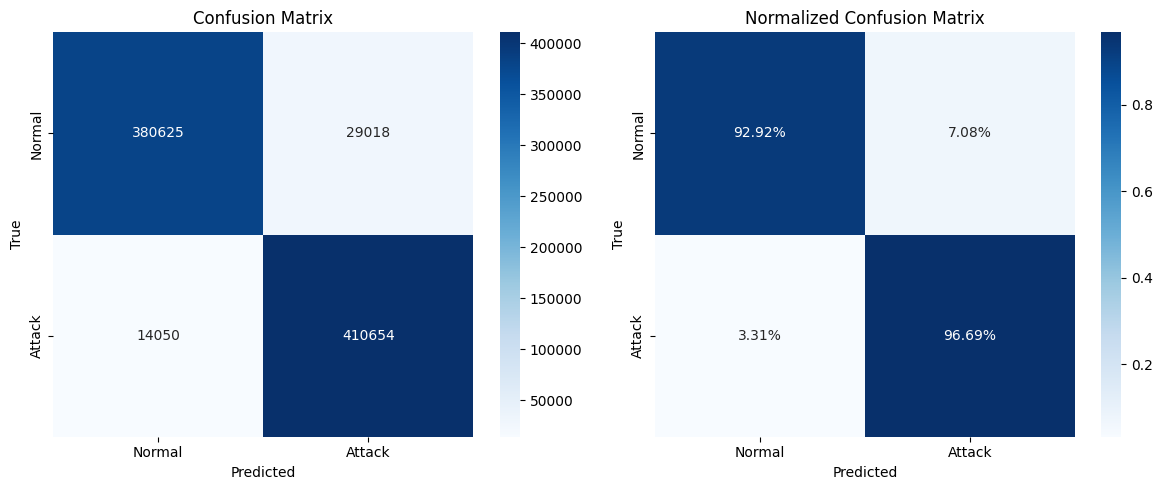

In [43]:
cm_normalized = cm / cm.sum(axis=1)[:, None]

fig, axes = plt.subplots(1, 2, figsize=(12,5))  # 1 row, 2 columns

# Raw Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Attack'], yticklabels=['Normal','Attack'], ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Normalized Confusion Matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Normal','Attack'], yticklabels=['Normal','Attack'], ax=axes[1])
axes[1].set_title("Normalized Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

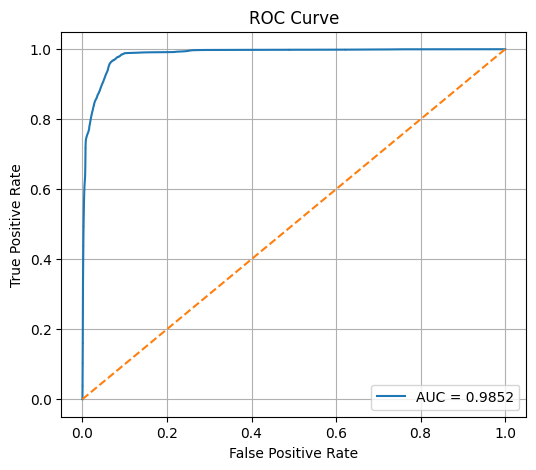

In [34]:
y_test_int = y_test.astype(int)
# Invert scores so higher = anomaly (positive class)
y_scores_inverted = -y_scores
fpr, tpr, thresholds = roc_curve(y_test_int, y_scores_inverted)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

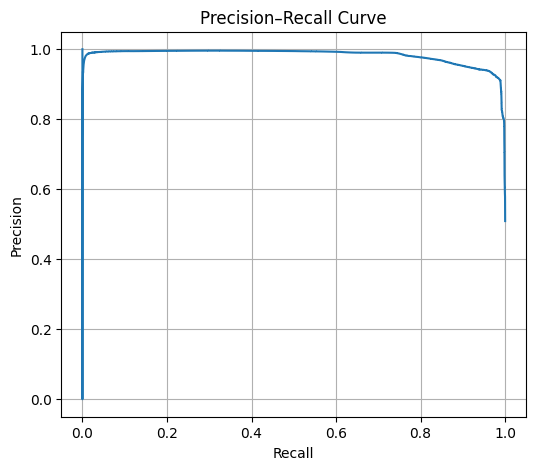

In [44]:
precision, recall, thresholds_pr = precision_recall_curve(y_test_int, y_scores_inverted)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()

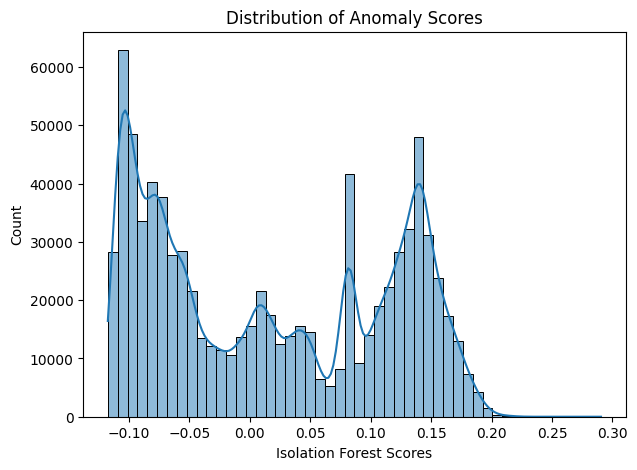

In [45]:
plt.figure(figsize=(7,5))
sns.histplot(y_scores_inverted, bins=50, kde=True)
plt.xlabel("Isolation Forest Scores")
plt.ylabel("Count")
plt.title("Distribution of Anomaly Scores")
plt.show()

In [ ]:
import joblib

project_root =r"C:\Users\Nourhan\Documents\Graduation Project\AI_CyberSecurity"
models_path = os.path.join(project_root, "Models")

joblib.dump(y_pred, os.path.join(models_path, "iso_preds.pkl"))